In [3]:
import torch
import itertools 
import transformers

import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 

def add_residual_connection(attentions_mat):
    """
    attentions_mat: (layer_num, head_num, seq_len, seq_len)
    """
    res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
    res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
    res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
    return res_att_mat

def compute_flows(G, labels_to_index, input_nodes, length):
    print(type(G))
    print(type(labels_to_index))
    print(type(input_nodes))
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    print(f"number of nodes:{number_of_nodes}")
    print(f"labels to index:{len(labels_to_index)}")
    print(f"input nodes:{len(input_nodes)}")
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                import time
                t1 = time.time()
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                print(f"{time.time()-t1}")
                flow_values[u][pre_layer*length+v] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def convert_adjmat_tomats(adjmat, n_layers, l):
    mats = np.zeros((n_layers,l,l))
    for i in np.arange(n_layers):
        mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
    return mats

def plot_attention_heatmap(att, s_position, t_positions, sentence):
    
  print(att[:,s_position, t_positions].shape)
  for idx, values in enumerate(att[:,s_position, t_positions]):
      print(f"idx:{idx} values:{values}")
  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax



In [5]:
def get_attention_flow(tokens, attentions_mat):
    """
    attentions_mat: (layer_num, head_num, seq_len, seq_len)
    """
    layer_num, head_num, seq_len, seq_len = attentions_mat.shape
    res_att_mat = add_residual_connection(attentions_mat)
    
    # Convert matrices to adjacency matrices
    res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

    #@title plot the attention graph
    plt.figure(figsize=(20,10))

    # res_adj_mat and res_labels_to_index are the results of get_adjmat()
    import time
    before = time.time()
    res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=layer_num, length=seq_len)
    after = time.time()
    print(f"t1:{after-before}")

    # Calculate the flow values
    input_nodes = []
    for key in res_labels_to_index:
        if res_labels_to_index[key] < seq_len:
            input_nodes.append(key)
    before = time.time()
    flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=seq_len)
    after = time.time()
    print(f"t2:{after-before}")

    # Convert adjacency matrix to matrices
    flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=layer_num, l=seq_len)

    return flow_att_mat

def draw_attention_flow(sentence, target_idx, flow_att_mat, indices_to_inspect=None):
    # Select source indices to inspect
    if indices_to_inspect is None:
        indices_to_inspect = list(range(sentence))
    
    # Plot the attention flow
    plt.figure(1,figsize=(3,6))
    plot_attention_heatmap(flow_att_mat, target_idx, t_positions=indices_to_inspect, sentence=sentence)

In [9]:
# Model
tokenizer = transformers.BertTokenizer.from_pretrained("bert-large-uncased")
model = transformers.BertForMaskedLM.from_pretrained("bert-large-uncased")

# Example
sentence = "The author talked to Sara about " + tokenizer.mask_token + " book"
tokens = ['[cls]'] + tokenizer.tokenize(sentence) + ['[sep]']
tf_input_ids = tokenizer.encode(sentence)
input_ids = torch.tensor([tf_input_ids])
print(f"Sentence: {sentence}")
print(f"input_ids:{input_ids}")

# Forward
all_attentions = model(input_ids, output_attentions=True).attentions
_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
attentions_mat = attentions_mat[:7]
print(f"attention shape:{attentions_mat.shape}")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentence: The author talked to Sara about [MASK] book
input_ids:tensor([[ 101, 1996, 3166, 5720, 2000, 7354, 2055,  103, 2338,  102]])
attention shape:(7, 16, 10, 10)


t1:3.2766149044036865
<class 'networkx.classes.digraph.DiGraph'>
<class 'dict'>
<class 'list'>
number of nodes:80
labels to index:80
input nodes:10
0.0033621788024902344
0.003089427947998047
0.002965688705444336
0.004694938659667969
0.004291534423828125
0.00405573844909668
0.0026433467864990234
0.0025413036346435547
0.002704620361328125
0.0025780200958251953
0.0027990341186523438
0.0029144287109375
0.002974271774291992
0.0027713775634765625
0.0027840137481689453
0.003094196319580078
0.0028002262115478516
0.0027992725372314453
0.0027790069580078125
0.002981901168823242
0.0028028488159179688
0.0028247833251953125
0.002991199493408203
0.003023386001586914
0.0027709007263183594
0.002777099609375
0.0030241012573242188
0.002819061279296875
0.0027313232421875
0.0026586055755615234
0.0028519630432128906
0.0027904510498046875
0.0028274059295654297
0.003070831298828125
0.0027806758880615234
0.002788543701171875
0.002901792526245117
0.002865314483642578
0.002784252166748047
0.0028526782989501953


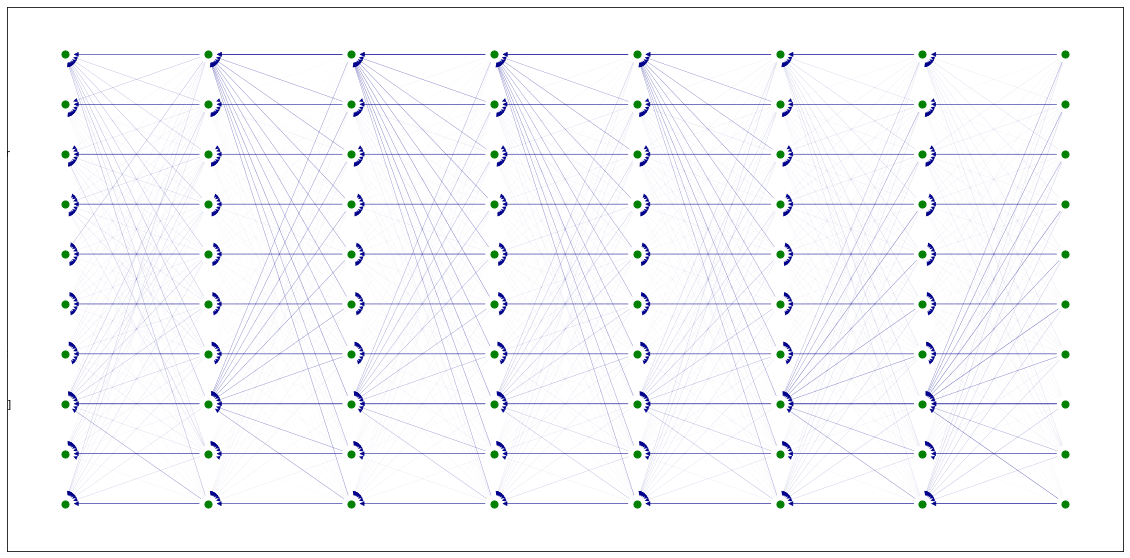

In [10]:
flow_att_mat = get_attention_flow(tokens, attentions_mat)

(7, 2)
idx:0 values:[0.01187017 0.01518553]
idx:1 values:[0.04210706 0.04718439]
idx:2 values:[0.0620468  0.06497105]
idx:3 values:[0.08550272 0.05571225]
idx:4 values:[0.09826307 0.05651417]
idx:5 values:[0.10967133 0.06445427]
idx:6 values:[0.10763556 0.07960638]


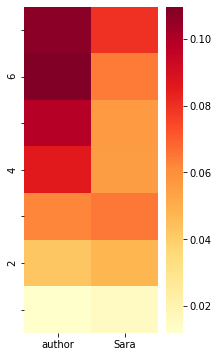

In [11]:
draw_attention_flow(sentence, 7, flow_att_mat, [2,5])